# Fine Tuning del ALS.

Eligiendo los mejores parametros para nuestro modelo.

Sabemos que un modelo ALS implícito se construye a partir de los parametros $rank$, $\lambda$, $maxIter$ y luego se adapta a los datos provistos en el entrenamiento.

Donde cada parametro significa:
> $rank (r)$: cantidad de factores que van a tener los vectores usuarios ($x_u$) e items ($y_i$). <br>
> $\lambda$: constante de regularizacion para evitar el overfitting. <br>
> $maxIter (M)$: maximo numero de iteraciones al dataset.

Luego, podemos definir multiples modelos como colecciones de $model_j$ ~ $ALS(r_j, \lambda_j, M_j)$.

<u>Observacion:</u> En la practica $als_j \leftrightarrow model_j = als_j.fit(ds)$

Para comparar los modelos vamos a usar las siguientes metricas:

* [1] Precision del modelo
* [2] Tiempo de entrenamiento

In [214]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import BisectingKMeans

from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, DataFrame
from pyspark.sql.functions import col, lit, udf
from pyspark.sql.types import *

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from models.utils import uutils
from models.interpreter import Interpreter

In [28]:
load_options = {"table": "view_events", "keyspace": "clarovideo"}
df = spark.read.format("org.apache.spark.sql.cassandra").options(**load_options).load()
df = df.withColumn("view", lit(1))

In [29]:
df.printSchema()

root
 |-- user_id: integer (nullable = false)
 |-- event: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- group_id: integer (nullable = true)
 |-- view: integer (nullable = false)



Voy a armar multiples datasets para ver las metricas en funcion a la cantidad de datos con los que es entrenado el modelo.

In [198]:
LENGTHS = [100, 1000, 5000, 10000, 25000, 50000]
datasets = [df.limit(length) for length in LENGTHS]

### Armamos los modelos que vamos a comparar.

In [206]:
RANKS = [5, 20, 40, 100]
MAX_ITERS = [3, 5, 10, 15]
REG_PARAMS = [0.01] # , 0.1, 0.5, 1.0

base_als = lambda r,m,l: ALS(maxIter=m, rank=r, regParam=l,
                             userCol='user_id',itemCol='group_id', ratingCol='view',implicitPrefs=True)

ALS_MODELS = [
    base_als(r,m,l) for r in RANKS for m in MAX_ITERS for l in REG_PARAMS
]

MODELS = [] # aca van a ir los modelos entrenados bajo un mismo dataset 

## [1] Tiempo de entrenamiento

Como para ver la precision del modelo necesitamos que este entrenado, primero vamos a ver la optimizacion segun tiempo de entrenamiento.

In [139]:
def compute_train_times(models) -> list():
    
    train_times = [] # aca guardo los tiempos de entrenamiento de cada modelo como una sublistas

    for j in trange(len(models)):

        als_model = models[j]
        model_times = []
        
        for ds in datasets:

            start_time = time.time()
            model = als_model.fit(ds)
            end_time = time.time()

            model_times.append(end_time - start_time)
            MODELS.append(model)
        
        train_times.append(model_times)
            
    return train_times

_train_times = compute_train_times(MODELS)

  0%|          | 0/16 [00:00<?, ?it/s]

23/07/14 18:36:54 WARN DAGScheduler: Broadcasting large task binary with size 1030.6 KiB
23/07/14 18:36:55 WARN DAGScheduler: Broadcasting large task binary with size 1073.0 KiB
23/07/14 18:36:55 WARN DAGScheduler: Broadcasting large task binary with size 1031.4 KiB
23/07/14 18:36:55 WARN DAGScheduler: Broadcasting large task binary with size 1115.5 KiB
23/07/14 18:36:55 WARN DAGScheduler: Broadcasting large task binary with size 1073.9 KiB
23/07/14 18:36:55 WARN DAGScheduler: Broadcasting large task binary with size 1157.9 KiB
23/07/14 18:36:55 WARN DAGScheduler: Broadcasting large task binary with size 1116.3 KiB
23/07/14 18:36:55 WARN DAGScheduler: Broadcasting large task binary with size 1200.4 KiB
23/07/14 18:36:56 WARN DAGScheduler: Broadcasting large task binary with size 1158.8 KiB
23/07/14 18:36:56 WARN DAGScheduler: Broadcasting large task binary with size 1242.8 KiB
23/07/14 18:36:56 WARN DAGScheduler: Broadcasting large task binary with size 1201.2 KiB
23/07/14 18:36:56 WAR

In [143]:
train_times = _train_times

In [150]:
times = []
for j, model in enumerate(MODELS):
    model_res = [
        (model.getRank(), model.getMaxIter(), model.getRegParam(), LENGTHS[k], train_times[j][k]) for k in range(len(train_times[j]))
       ]
    times.extend(model_res)

times_df = pd.DataFrame(times, columns=["rank", "max_iter", "reg_param", "length", "train_times"])
times_df.head()

,rank,max_iter,reg_param,length,train_times
0,5,3,0.01,100,3.521354
1,5,3,0.01,1000,4.056135
2,5,3,0.01,5000,6.853392
3,5,3,0.01,10000,10.334830
4,5,3,0.01,25000,22.035727


#### Correlacion Pearson

Vemos la correlacion lineal entre los parametros y el train_times

$$\rho_{X, Y} = \frac{Cov(X,Y)}{\sqrt{Var(X)Var(Y)}}$$

Donde $\rho_{X, Y} \in [-1, 1]$ y se interpreta: 
* $\rho_{X, Y} \rightarrow 1$: Existe una fuerte relacion directamente proporcional (cuando crece una, crece la otra) 
* $\rho_{X, Y} \rightarrow 0$: No existe correlacion lineal (no implica que sean independientes) 
* $\rho_{X, Y} \rightarrow -1$: Existe una fuerte relacion inversamente proporcional (cuando crece una, decrece la otra) 

In [152]:
# correlacion pearson
times_df.corr(method="pearson")

,rank,max_iter,reg_param,length,train_times
rank,1.000000e+00,2.534448e-16,NaN,3.044494e-17,0.322405
max_iter,2.534448e-16,1.000000e+00,NaN,3.320673e-17,0.184147
reg_param,NaN,NaN,NaN,NaN,NaN
length,3.044494e-17,3.320673e-17,NaN,1.000000e+00,0.831795
train_times,3.224046e-01,1.841467e-01,NaN,8.317948e-01,1.000000


Como vemos, levemente hay una relacion directamente proporcional y lineal entre $rank$ y train_times, asi como entre $maxIter$ y train_times.

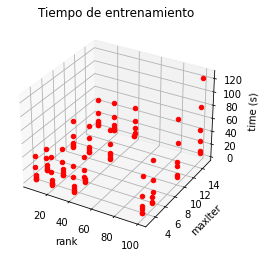

In [191]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.title.set_text('Tiempo de entrenamiento')

ax.set_xlabel('rank')
ax.set_ylabel('maxIter')
ax.set_zlabel('time (s)')

for i, model in enumerate(MODELS):
    rank = model.getRank()
    maxIter = model.getMaxIter()
    for t in train_times[i]:
        ax.scatter(rank, maxIter, t, color="red")   

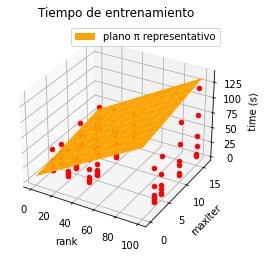

In [197]:
## Agrego un plano para proyectar los puntos 

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.title.set_text('Tiempo de entrenamiento')

ax.set_xlabel('rank')
ax.set_ylabel('maxIter')
ax.set_zlabel('time (s)')

for i, model in enumerate(MODELS):
    rank = model.getRank()
    maxIter = model.getMaxIter()
    for t in train_times[i]:
        ax.scatter(rank, maxIter, t, color="red")   

xdata = np.linspace(0,100,10)
ydata = np.linspace(0,16,10)
X,Y = np.meshgrid(xdata,ydata)
Z = 1.6*Y + 1.0*X + 9

surf=ax.plot_surface(X, Y, Z, color="orange", label="plano π representativo") 
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d
ax.legend(handles=[surf])

## [2] Precision del modelo

Vamos a ver la precision ($A$) del modelo usando la recomendacion para usuarios. 

$$A = \frac{\# VistasBuenas}{\# Vistas} $$

Donde:
* $VistasBuenas$: cantidad de items recomendados al usuario que despues fueron vistos en el test_ds.
* $Vistas$: cantidad de vistas del usuario en el test_ds.

In [224]:
train, test = datasets[1].randomSplit([0.8, 0.2], seed=0)

In [250]:
# por una cuestion de performance, 
# voy a pasar las u_recomendaciones a un formato como el df original de las vistas

def recommendations_to_views_format(recommendations) -> DataFrame:
    global spark
    gg = []
    for user_id, recs in recommendations.collect():
        for group_id, rating in recs:
            gg.append({"user_id": user_id, "group_id": group_id})
    return spark.createDataFrame(gg)

In [281]:
def compute_precision(model, train, users_in_test, n_recs=100) -> float:

    # dejo en el test_df solo los que tengan ids en comun con train_df    
    util_test_df = train.filter(train.user_id.isin(users_in_test))

    # recomiendo para todos los usuarios en comun en el train_df y test_df
    u_recommendations = model.recommendForUserSubset(util_test_df, n_recs)
    # paso las recomendaciones al mismo formato que el test
    u_recommendations_as_df = recommendations_to_views_format(u_recommendations)

    # me fijo filas en comun entre el test y las recomendaciones
    test_ug = test.select("user_id", "group_id")
    recs_ug = u_recommendations_as_df.select("user_id", "group_id")

    score = test_ug.intersect(recs_ug).count() / test_ug.count()
    
    return score

In [282]:
model = ALS_MODELS[0].fit(train)
users_in_test = set([i.user_id for i in test.select("user_id").collect()])

In [283]:
compute_precision(model, train, users_in_test)

0.02358490566037736